# Variance optimization
This notebook demonstrates the effect of the relative error tolerance.

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qaoa import *
from pylab import cm
from timeit import default_timer as timer

from matplotlib import rc,patches
from scipy import optimize as opt

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeOurense

# Parameters when sampling the entire parameter space
SAMPLING_E_ATOL = 8e-2
SAMPLING_E_RTOL = 4e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 128#8192
MAX_SAMPLES = 32768*8#8192
SAMPLING_CONF_IDX = 2
LANDSCAPE_RESOLUTION = 8

# Other parameters
CORRELATION_FRAC = 0.1
WEIGHT_DECIMALS = 0
NOISY = 0
MOCK = (NOISY == 2)
OPTIMIZATION_LEVEL = 2
GRAPH_SEED = 51
CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 2

# Parameters for error tolerance iterations
N_INITIAL_GAMMA = 2
N_INITIAL_BETA = 2
N_REPS = 64
MIN_ALPHA = 0
MAX_ALPHA = 1
N_ALPHA = 5
N_INITIAL_POINTS = (N_INITIAL_GAMMA * N_INITIAL_BETA)**CIRCUIT_DEPTH


font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

100%
Max cost: 6


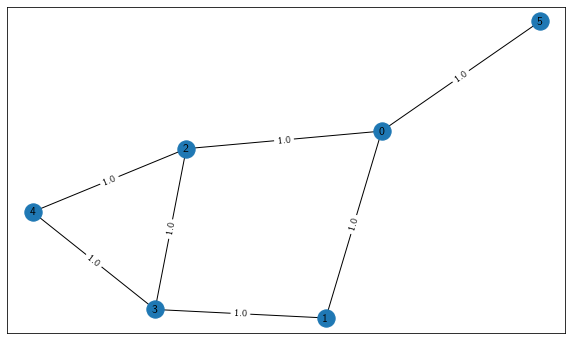

In [2]:
#V = np.arange(0,5,1)
V = np.arange(0,6,1)
E =[(0,1),(0,2),(2,3),(3,1),(3,4),(4,2),(0,5)]
#E =[(0,1),(0,2),(2,3),(3,1),(3,4),(4,2)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

np.random.seed(GRAPH_SEED)
addWeights_MaxCut(G,decimals=WEIGHT_DECIMALS)

pl.figure(figsize=(10,6))
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
execute_backend = Aer.get_backend('qasm_simulator')

if NOISY == 1:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    noise_backend = provider.get_backend('ibmq_ourense')
    transpile_backend = noise_backend
elif NOISY == 2:
    execute_backend = FakeOurense()
    transpile_backend = execute_backend
    noise_backend = execute_backend
else:
    noise_backend = None
    transpile_backend = execute_backend
    
if noise_backend == None:
    noise_model = None
else:
    noise_model = NoiseModel.from_backend(noise_backend.properties())

Prepare the initial points from which we will do the optimizations.

In [4]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [5]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=WEIGHT_DECIMALS)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

delta_gamma = (gamma_max-gamma_min)/N_INITIAL_GAMMA
delta_beta = (beta_max-beta_min)/N_INITIAL_BETA

initial_gammas = np.linspace(gamma_min+delta_gamma/2,gamma_max-delta_gamma/2,N_INITIAL_GAMMA)
initial_betas = np.linspace(beta_min+delta_beta/2,beta_max-delta_beta/2,N_INITIAL_BETA)

initial_points = cartesian((initial_gammas,initial_betas)*CIRCUIT_DEPTH)

Now we iterate over each of **N_ALPHA** alphas. For each of them, do **N_REPS** optimization runs at each of the **N_INITIAL_POINTS** parameters space lattice points.

In [6]:
# Alpha denotes the relative expectation-variance weighting in the cost function
def getval(x,history_ref,execute_backend,depth,version,noise_model,E_atol,E_rtol,dv_rtol,
           min_n_shots,max_n_shots,conf_idx,alpha,mock,optimization_level):
    circuit = createCircuit_MaxCut(x,G,depth,version)
    
    transpiled_circuit = transpile(circuit,backend=transpile_backend,optimization_level=optimization_level)
    [E_list,v_list,n_list] = sampleUntilPrecision_MaxCut(transpiled_circuit,G,execute_backend,noise_model,
                                                                min_n_shots,max_n_shots,E_atol,E_rtol,dv_rtol,
                                                                conf_idx,mock=mock)

    history_ref['gammas'].append(x[0])
    history_ref['betas'].append(x[1])
    history_ref['expectations'].append(E_list)
    history_ref['variances'].append(v_list)
    history_ref['n_shots'].append(n_list)
        
    return -(1-alpha)*E_list[-1]+alpha*v_list[-1]

In [7]:
alphas = np.linspace(MIN_ALPHA,MAX_ALPHA,N_ALPHA)

opt_histories = []
timer_start = timer()
for i in range(N_ALPHA):
    alpha = alphas[i]
    
    opt_histories.append([])
    for j in range(N_INITIAL_POINTS):
        x0 = initial_points[j]
        
        timer_start = timer()
        opt_histories[i].append([])
        for k in range(N_REPS):
        
            opt_history = {
                'gammas': [],
                'betas': [],
                'expectations': [],
                'variances': [],
                'n_shots': [],
            }
            opt.minimize(getval, x0=x0, method='COBYLA',
                             args=(opt_history,execute_backend,CIRCUIT_DEPTH,CIRCUIT_VERSION,noise_model,
                                   SAMPLING_E_ATOL,SAMPLING_E_RTOL,SAMPLING_DELTA_V_RTOL,MIN_SAMPLES,MAX_SAMPLES,
                                   SAMPLING_CONF_IDX,alpha,MOCK,OPTIMIZATION_LEVEL),
                             options={'rhobeg': 1e-1, 'disp': True, 'maxiter': 10000})
            
            opt_histories[i][j].append(opt_history)
            timer_end = timer()
            progress = (i*N_INITIAL_POINTS*N_REPS+j*N_REPS+k+1)/(N_ALPHA*N_INITIAL_POINTS*N_REPS)
            remaining_time = (timer_end-timer_start)*(1/progress-1)
            print('%.2f%% (T-%.2f sec)' % (progress*100,remaining_time),end='\r')  
        


Finally we plot histograms for the achieved optimization ratios, as well as iterations and total shots per optimization.

<Figure size 432x288 with 0 Axes>

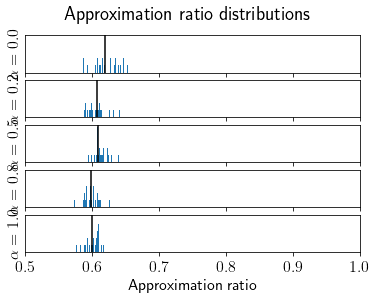

<Figure size 432x288 with 0 Axes>

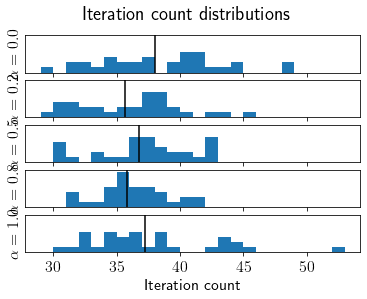

<Figure size 432x288 with 0 Axes>

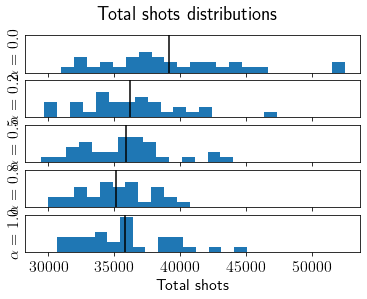

In [8]:
n_datapoints = N_REPS*N_INITIAL_POINTS

apx_ratios = np.zeros((N_ALPHA,n_datapoints))
n_itss = np.zeros((N_ALPHA,n_datapoints))
n_shotss = np.zeros((N_ALPHA,n_datapoints))


for i in range(N_ALPHA):
    for j in range(N_INITIAL_POINTS):
        for k in range(N_REPS):
            opt_history = opt_histories[i][j][k]
            
            n_shots_list = [sum(x) for x in opt_history['n_shots']]
            E = opt_history['expectations'][-1]
            
            tot_n_shots = sum(n_shots_list)
            n_its = len(n_shots_list)
            apx_ratio = E[-1]/max_cost

            flat_idx = j*N_REPS + k
            apx_ratios[i,flat_idx] = apx_ratio
            n_itss[i,flat_idx] = n_its
            n_shotss[i,flat_idx] = tot_n_shots
            
pl.figure()
_,axs = pl.subplots(N_ALPHA,1,sharex=True,sharey='col')
for i in range(N_ALPHA):
    binsize = 0.001
    apx_ratios_flat = apx_ratios[i].flatten()
    n_bins = int(np.ceil((max(apx_ratios_flat)-min(apx_ratios_flat))/binsize))
    
    axs[i].hist(apx_ratios_flat,n_bins,label='Distribution, $\\alpha=%.2e$'%alphas[i])
    axs[i].axvline(np.average(apx_ratios_flat),color='k')
    axs[i].set_ylabel('$\\alpha = %.1f$' % alphas[i])
    axs[i].set_yticks([])
    axs[i].set_xlim(0.5,1.0)
pl.xlabel('Approximation ratio')
pl.suptitle('Approximation ratio distributions')
pl.savefig('var_alpha_E_pdf_p%d_noise%d.svg'%(CIRCUIT_DEPTH,NOISY))
pl.savefig('var_alpha_E_pdf_p%d_noise%d.png'%(CIRCUIT_DEPTH,NOISY))

pl.figure()
_,axs = pl.subplots(N_ALPHA,1,sharex=True,sharey='col')
for i in range(N_ALPHA):
    binsize = 1
    n_its_flat = n_itss[i].flatten()
    n_bins = int(np.ceil((max(n_its_flat)-min(n_its_flat))/binsize))
    
    axs[i].hist(n_its_flat,n_bins,label='Distribution, $\\alpha=%.2e$'%alphas[i])
    axs[i].axvline(np.average(n_its_flat),color='k')
    axs[i].set_ylabel('$\\alpha=%.1f$' % alphas[i])
    axs[i].set_yticks([])
pl.xlabel('Iteration count')
pl.suptitle('Iteration count distributions')
pl.savefig('var_alpha_its_pdf_p%d_noise%d.svg'%(CIRCUIT_DEPTH,NOISY))
pl.savefig('var_alpha_its_pdf_p%d_noise%d.png'%(CIRCUIT_DEPTH,NOISY))

pl.figure()
_,axs = pl.subplots(N_ALPHA,1,sharex=True,sharey='col')
for i in range(N_ALPHA):
    binsize = 1000
    n_shots_flat = n_shotss[i].flatten()
    n_bins = int(np.ceil((max(n_shots_flat)-min(n_shots_flat))/binsize))
    
    axs[i].hist(n_shots_flat,n_bins,label='Distribution, $\\alpha=%.2e$'%alphas[i])
    axs[i].axvline(np.average(n_shots_flat),color='k')
    axs[i].set_ylabel('$\\alpha=%.1f$' % alphas[i])
    axs[i].set_yticks([])
pl.xlabel('Total shots')
pl.suptitle('Total shots distributions')
pl.savefig('var_alpha_shots_pdf_p%d_noise%d.svg'%(CIRCUIT_DEPTH,NOISY))
pl.savefig('var_alpha_shots_pdf_p%d_noise%d.png'%(CIRCUIT_DEPTH,NOISY))